In [ ]:
# %%
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# For inline plotting in Jupyter Notebook
%matplotlib inline


In [16]:
# %%
# Replace 'your_file.csv' with the path to your CSV file.
df = pd.read_csv('data_preprocessed_with_all_sectors.csv')
print("DataFrame Head:")
print(df.head())


DataFrame Head:
      Price  Price/Earnings  Dividend_Yield  Earnings/Share  52_Week_Low  \
0  0.878344       -0.008454        0.280215        0.743147     0.875014   
1 -0.324371        0.076259       -0.489462       -0.382941    -0.349252   
2 -0.353727       -0.052652        0.004876       -0.643643    -0.373496   
3  0.032340       -0.128771        0.388497       -0.095082     0.018386   
4  0.343130        0.020029       -0.121474        0.294160     0.253414   

   52_Week_High  Market_Cap    EBITDA  Price/Sales  Price/Book  ...  \
0      0.861718    0.986142  0.796009     0.125507   -0.035195  ...   
1     -0.327918   -0.425974 -0.432863    -0.108525   -0.090795  ...   
2     -0.390377    0.582168  0.315342    -0.061133   -0.126005  ...   
3     -0.223349    1.457061  0.979604     0.671617    0.129711  ...   
4      0.291456    0.545135  0.300682    -0.387530   -0.043217  ...   

   Sector_Consumer Staples  Sector_Energy  Sector_Financials  \
0                      0.0          

In [26]:
# Separate features and target (avoid leakage by dropping the target from features).
features = df.drop('Price', axis=1)
target = df['Price']

# Initialize scalers for features and target (using StandardScaler for better normalization).
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Scale features.
features_scaled_array = feature_scaler.fit_transform(features)
features_scaled = pd.DataFrame(features_scaled_array, columns=features.columns)

# Scale target (reshaping is needed because the scaler expects a 2D array).
target_scaled_array = target_scaler.fit_transform(target.values.reshape(-1, 1))
target_scaled = pd.Series(target_scaled_array.flatten())

# Function to create sliding windows.
def create_windows(features, target, window_size):
    """
    Create sliding windows for the features and corresponding target values.
    
    Parameters:
      features (DataFrame): Scaled input features.
      target (Series): Scaled target variable.
      window_size (int): Number of consecutive days per sample.
      
    Returns:
      X: NumPy array of shape (num_samples, window_size, num_features)
      y: NumPy array of target values for each sample.
    """
    X = []
    y = []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i+window_size].values)
        y.append(target.iloc[i+window_size])
    return np.array(X), np.array(y)

# Set window size to 20 days (increased from 10 for deeper temporal dependencies).
window_size = 10
X, y = create_windows(features_scaled, target_scaled, window_size)

print("Shape of input (X):", X.shape)  # Expected: (num_samples, 20, num_features)
print("Shape of target (y):", y.shape)

Shape of input (X): (485, 10, 20)
Shape of target (y): (485,)


In [27]:
# Split the data into training (85%) and testing (15%) sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])

# Determine input dimensions.
n_timesteps = X_train.shape[1]  # Should be 20 (window size)
n_features = X_train.shape[2]   # Number of features

Training samples: 412
Testing samples: 73


In [28]:
# Set hyperparameters.
l2_lambda = 0.0001      # Reduced L2 regularization strength
dropout_rate = 0.2       # Reduced dropout rate
learning_rate = 0.001   # Reduced learning rate

model = Sequential()

# --- Convolutional Block ---
# First Conv1D layer with 64 filters.
model.add(Conv1D(filters=64, 
                 kernel_size=3, 
                 activation='relu', 
                 padding='same', 
                 input_shape=(n_timesteps, n_features),
                 kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Second Conv1D layer with 64 filters.
model.add(Conv1D(filters=64, 
                 kernel_size=3, 
                 activation='relu', 
                 padding='same',
                 kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Third Conv1D layer for finer-grained patterns.
model.add(Conv1D(filters=32, 
                 kernel_size=2, 
                 activation='relu', 
                 padding='same',
                 kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))  # Downsample with max pooling.
model.add(Dropout(dropout_rate))

# --- Bidirectional LSTM Block ---
# Bidirectional LSTM layer to capture richer temporal dependencies.
model.add(Bidirectional(LSTM(64, 
                            activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=l2(l2_lambda))))
model.add(Dropout(dropout_rate))

model.add(Bidirectional(LSTM(32, 
                            activation='tanh', 
                            return_sequences=False, 
                            kernel_regularizer=l2(l2_lambda))))
model.add(Dropout(dropout_rate))

# --- Dense Block ---
# Additional Dense layers to increase capacity.
model.add(Dense(64, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(Dropout(dropout_rate))

model.add(Dense(32, activation='relu', kernel_regularizer=l2(l2_lambda)))
model.add(Dropout(dropout_rate))

# Output layer for regression.
model.add(Dense(1, activation='linear'))

# Compile the model with reduced learning rate.
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse')

model.summary()

2025-03-12 20:42:18.339750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-12 20:42:18.342605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-12 20:42:18.343325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 10, 64)            3904      
                                                                 
 batch_normalization_9 (Batc  (None, 10, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_17 (Dropout)        (None, 10, 64)            0         
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 64)            12352     
                                                                 
 batch_normalization_10 (Bat  (None, 10, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 10, 64)           

In [29]:
# Define callbacks.
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

# Compile the model with a fixed learning rate.
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')

# Train the model.
history = model.fit(
    X_train, y_train,
    epochs=200,            # Increased maximum epochs.
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/200


2025-03-12 20:42:22.809502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-12 20:42:22.810429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-12 20:42:22.811492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

 7/13 [===============>..............] - ETA: 0s - loss: 1.5044 

2025-03-12 20:42:25.969996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-12 20:42:25.971562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-12 20:42:25.972333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

13/13 [==============================] - 4s 78ms/step - loss: 1.1254 - val_loss: 0.8671 - lr: 1.0000e-04
Epoch 2/200
13/13 [==============================] - 0s 8ms/step - loss: 1.1145 - val_loss: 0.8677 - lr: 1.0000e-04
Epoch 3/200
13/13 [==============================] - 0s 7ms/step - loss: 1.1029 - val_loss: 0.8687 - lr: 1.0000e-04
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 1.1234 - val_loss: 0.8688 - lr: 1.0000e-04
Epoch 5/200
13/13 [==============================] - 0s 8ms/step - loss: 1.1246 - val_loss: 0.8683 - lr: 1.0000e-04
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 1.1244 - val_loss: 0.8680 - lr: 1.0000e-04
Epoch 7/200
13/13 [==============================] - 0s 7ms/step - loss: 1.0985 - val_loss: 0.8668 - lr: 1.0000e-04
Epoch 8/200
13/13 [==============================] - 0s 8ms/step - loss: 1.1287 - val_loss: 0.8653 - lr: 1.0000e-04
Epoch 9/200
13/13 [==============================] - 0s 8ms/step - loss: 1.1305 - v

In [30]:
# Evaluate the model on the test set.
test_loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)

# Generate predictions.
y_pred = model.predict(X_test)

# Invert scaling to get back to the original target scale.
y_test_inv = target_scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = target_scaler.inverse_transform(y_pred)

# Calculate evaluation metrics.
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print("\nEvaluation Metrics on Test Set (Inverse Transformed):")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")

3/3 [==============================] - 0s 2ms/step - loss: 0.3983
Test Loss (MSE): 0.3982509970664978


2025-03-12 20:42:44.677700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-03-12 20:42:44.678372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-03-12 20:42:44.679307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

3/3 [==============================] - 1s 2ms/step

Evaluation Metrics on Test Set (Inverse Transformed):
Mean Squared Error (MSE): 0.3385
Root Mean Squared Error (RMSE): 0.5818
Mean Absolute Error (MAE): 0.4121
R² Score: 0.5766


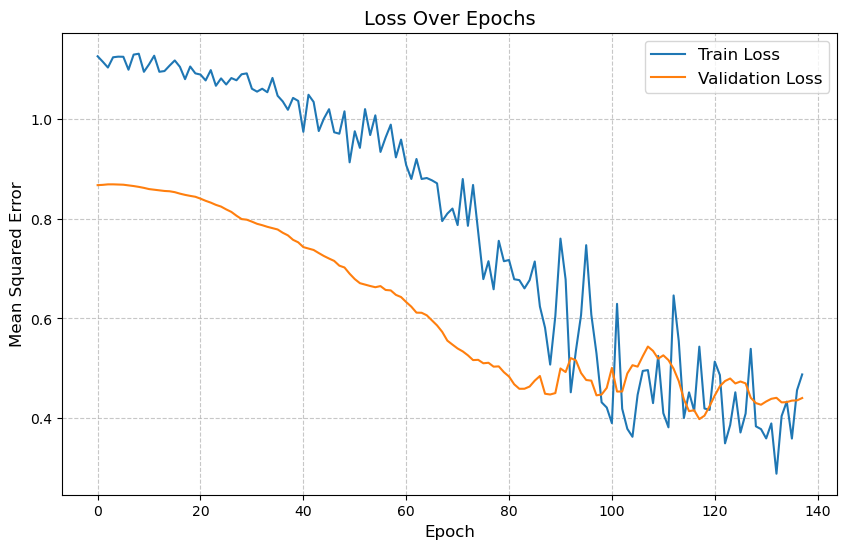

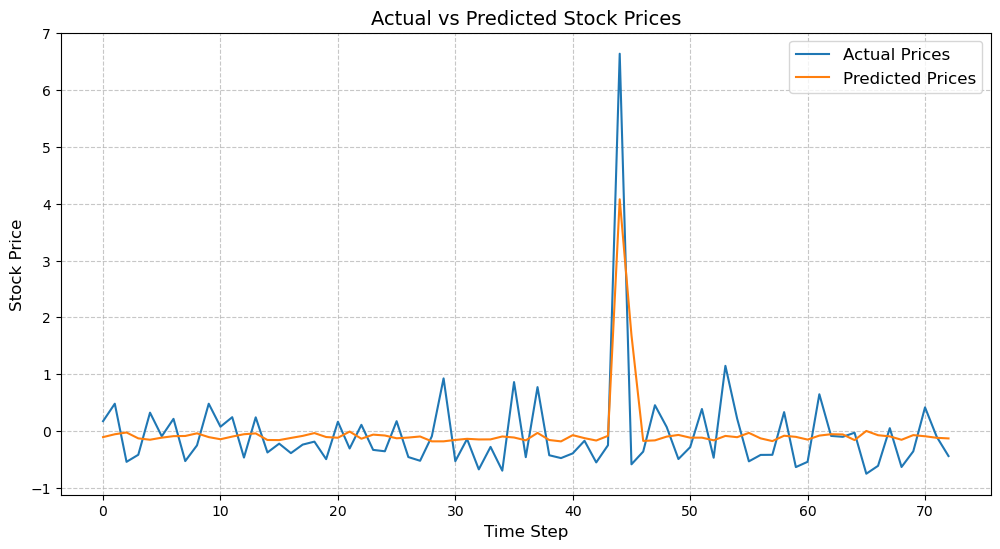

In [34]:
# Plot training and validation loss over epochs.
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Mean Squared Error', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# Plot Actual vs Predicted Prices as Time Series
plt.figure(figsize=(12, 6))

# Get the test set indices for proper alignment.
test_indices = range(len(y_test_inv))

# Plot actual prices.
plt.plot(test_indices, y_test_inv, label='Actual Prices' )

# Plot predicted prices.
plt.plot(test_indices, y_pred_inv, label='Predicted Prices')

# Add labels and title.
plt.title('Actual vs Predicted Stock Prices', fontsize=14)
plt.xlabel('Time Step', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)

# Add legend and grid.
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot.
plt.show()